# WINGS Full Pipeline: Machine Precision Optimization

This notebook tests the complete optimization chain targeting machine-level precision.

**Full Pipeline Stages:**
1. **Smart Initialization** → Good starting point (F ~ 0.3-0.7)
2. **Adam Optimization** → Fast convergence to F ~ 0.99
3. **Basin Hopping + L-BFGS** → Escape local minima, reach F ~ 0.999999
4. **Final L-BFGS Refinement** → Machine precision (F > 0.9999999999)

**Target:** Infidelity < 1e-10 (Fidelity > 0.9999999999)

**Expected Runtime:** 5-30 minutes depending on GPU availability

## 0. Setup

In [1]:
# ============================================================================
# PATH SETUP - Run after kernel restart
# ============================================================================
import sys
from pathlib import Path

# Clean sys.path and add correct source
# Modify 'optimization-files' to match your folder name
PROJECT_FOLDER = 'optimization-files'  # <-- CHANGE THIS if needed

src_path = Path.cwd() / PROJECT_FOLDER / 'src'

# Remove old paths that might conflict
sys.path = [p for p in sys.path if 'gaussian_state_optimizer' not in p]

if src_path.exists():
    sys.path.insert(0, str(src_path))
    print(f"✓ Added to path: {src_path}")
else:
    print(f"✗ Path not found: {src_path}")
    print("  Trying current directory...")
    # Maybe notebooks are inside the package
    alt_path = Path.cwd().parent / 'src'
    if alt_path.exists():
        sys.path.insert(0, str(alt_path))
        print(f"✓ Added alternate path: {alt_path}")

✓ Added to path: /home/jmc03846/WINGS_debug/optimization-files/src


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

from gaussian_state_optimizer import (
    GaussianOptimizer,
    OptimizerConfig,
    TargetFunction,
)
from gaussian_state_optimizer.config import OptimizationPipeline

print("✓ All imports successful")

# Check backends
try:
    from gaussian_state_optimizer import get_backend_info, print_backend_info
    print_backend_info()
    backend_info = get_backend_info()
    HAS_CUSTATEVEC = backend_info['custatevec']
except:
    print("Backend detection not available")
    HAS_CUSTATEVEC = False

print(f"\nUsing cuStateVec: {HAS_CUSTATEVEC}")

def get_statevector_for_plotting(opt, params):
    """Get statevector in correct ordering for plotting."""
    if opt.config.use_custatevec and hasattr(opt, '_custatevec_evaluator') and opt._custatevec_evaluator is not None:
        return opt._custatevec_evaluator.get_statevector_qiskit_order(params)
    else:
        return opt.get_statevector(params)

Detected HPC scratch directory: /scratch/jmc03846
Created/verified directory: /home/jmc03846/lib
Created/verified directory: /scratch/jmc03846/coefficient_cache
Created/verified directory: /scratch/jmc03846/simulation_output
Created/verified directory: /scratch/jmc03846/simulation_data
Created/verified directory: /scratch/jmc03846/optimization_checkpoints
Created/verified directory: /scratch/jmc03846/optimization_campaigns
✓ All imports successful
Gaussian State Optimizer - Backend Information
  CPU (Qiskit Statevector): ✓ Available
  GPU (Qiskit Aer):         ✓ Available
  cuStateVec:               ✓ Available

Using cuStateVec: True


## 1. Configuration

We'll test with 8 qubits (256 grid points, 64 parameters) which is a good balance of:
- Challenging enough to need the full pipeline
- Fast enough to complete in reasonable time

In [3]:
# Optimizer configuration
N_QUBITS = 8
SIGMA = 0.5

config = OptimizerConfig(
    n_qubits=N_QUBITS,
    sigma=SIGMA,
    x0=0.0,
    box_size=4.0,
    target_function=TargetFunction.GAUSSIAN,
    verbose=True,
    
    # GPU settings - use cuStateVec if available
    use_gpu=False,
    use_custatevec=HAS_CUSTATEVEC,
    gpu_precision='double',
)

print(f"Configuration:")
print(f"  Qubits: {config.n_qubits}")
print(f"  Grid points: {config.n_states}")
print(f"  Parameters: {config.n_params}")
print(f"  Sigma: {config.sigma}")
print(f"  cuStateVec: {config.use_custatevec}")

Using user-specified box size: +/-4.00
Target function: gaussian
Parallelization: 63 workers, backend='thread'
Configuration:
  Qubits: 8
  Grid points: 256
  Parameters: 64
  Sigma: 0.5
  cuStateVec: True


In [4]:
# Create optimizer
optimizer = GaussianOptimizer(config)
print(f"✓ Optimizer created")


Initializing cuStateVec acceleration...
  ✓ cuStateVec initialized
    Precision: double
    Batch simulators: 4
✓ Optimizer created


## 2. Full Pipeline Configuration

This is the complete 4-stage pipeline for machine precision:

```
Smart Init → Adam → Basin Hopping + L-BFGS → Final L-BFGS
   (0.5)      (0.99)      (0.999999)         (0.9999999999+)
```

In [5]:
# Full pipeline for machine precision
full_pipeline = OptimizationPipeline(
    mode='adaptive',
    
    # Target: infidelity < 1e-10
    target_fidelity=1.0 - 1e-10,
    target_infidelity=1e-10,
    
    # Time limits
    max_total_time=600,  # 10 minutes max
    
    # =========================================
    # Stage 1: Adam (fast initial convergence)
    # =========================================
    use_adam_stage=True,
    adam_max_steps=5000,
    adam_lr=0.01,
    
    # =========================================
    # Stage 2: Basin Hopping (escape local minima)
    # =========================================
    use_basin_hopping=True,
    basin_hopping_iterations=100,

    # =========================================
    # Stage 3: L-BFGS Refinement (machine precision)
    # =========================================
    use_lbfgs_refinement=True,
    
    verbose=True,
)

print("Full Pipeline Configuration")
print("=" * 60)
print(f"Target fidelity:     {full_pipeline.target_fidelity}")
print(f"Target infidelity:   {full_pipeline.target_infidelity:.0e}")
print(f"Max time:            {full_pipeline.max_total_time}s")
print()

Full Pipeline Configuration
Target fidelity:     0.9999999999
Target infidelity:   1e-10
Max time:            600s



## 3. Run Full Pipeline

In [6]:
print("="*70)
print("STARTING FULL OPTIMIZATION PIPELINE")
print("="*70)
print(f"Target: Infidelity < 1e-10")
print(f"This may take 5-30 minutes...")
print("="*70 + "\n")

start_time = time.time()

# Run the full pipeline
results = optimizer.run_optimization(full_pipeline)

total_time = time.time() - start_time

print("\n" + "="*70)
print("OPTIMIZATION COMPLETE")
print("="*70)

STARTING FULL OPTIMIZATION PIPELINE
Target: Infidelity < 1e-10
This may take 5-30 minutes...


OPTIMIZATION PIPELINE: ADAPTIVE
  Target fidelity:   0.9999999999
  Target infidelity: 1e-10
  Max time:          600s

STAGE: Initialization Search
  smart               : F = 0.00026859
  gaussian_product    : F = 0.00084045
  random              : F = 0.00331895
  random              : F = 0.00159980
  random              : F = 0.00778724

Best initialization: 'random' with F = 0.00778724

STAGE: Adam Exploration
  Time budget: 600s

Adam Optimization (lr=0.01, max_steps=5000)
--------------------------------------------------
  Step     0: F=0.0077872447, |∇|=4.81e-02, lr=0.0100
  Step   100: F=0.7957701279, |∇|=1.88e-01, lr=0.0051
  Time limit reached at step 117

Adam complete: F=0.847071545795 in 603.1s (118 steps)

After Adam: F = 0.847071545795
  Infidelity: 1.529e-01

OPTIMIZATION COMPLETE
Final fidelity:      0.847071545794578
Infidelity:          1.529e-01
Target infidelity:   1.0

In [7]:
# Display results
print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)
print(f"  Fidelity:           {results['fidelity']:.15f}")
print(f"  Infidelity (1-F):   {results.get('infidelity', 1-results['fidelity']):.6e}")
print(f"  Total time:         {total_time:.1f}s ({total_time/60:.1f} min)")
print(f"  Function evals:     {results.get('n_evaluations', 'N/A')}")
print(f"  Success:            {results.get('success', 'N/A')}")

# Stage-by-stage results if available
if 'stage_results' in results:
    print("\nStage-by-stage:")
    for stage, stage_res in results['stage_results'].items():
        print(f"  {stage}: F={stage_res.get('fidelity', 'N/A'):.10f}, time={stage_res.get('time', 'N/A'):.1f}s")

# Check if we achieved target
infidelity = 1 - results['fidelity']
target_achieved = infidelity < 1e-10

print("\n" + "="*70)
if target_achieved:
    print(f"✓ TARGET ACHIEVED: Infidelity {infidelity:.2e} < 1e-10")
else:
    print(f"⚠ Target not achieved: Infidelity {infidelity:.2e} >= 1e-10")
    print(f"  Consider: more iterations, different initialization, or larger circuit")
print("="*70)


FINAL RESULTS
  Fidelity:           0.847071545794578
  Infidelity (1-F):   1.529285e-01
  Total time:         603.4s (10.1 min)
  Function evals:     0
  Success:            False

⚠ Target not achieved: Infidelity 1.53e-01 >= 1e-10
  Consider: more iterations, different initialization, or larger circuit


## 4. Verify Results

In [8]:
# Verify the optimal parameters reproduce the reported fidelity
optimal_params = results['optimal_params']

# Recompute fidelity
verify_fidelity = optimizer.compute_fidelity(params=optimal_params)

print(f"Verification:")
print(f"  Reported fidelity:   {results['fidelity']:.15f}")
print(f"  Recomputed fidelity: {verify_fidelity:.15f}")
print(f"  Match: {np.isclose(results['fidelity'], verify_fidelity, rtol=1e-10)}")

Verification:
  Reported fidelity:   0.847071545794578
  Recomputed fidelity: 0.847071545794578
  Match: True


In [9]:
# Get the optimal statevector (in correct order for plotting)
optimal_sv = get_statevector_for_plotting(optimizer, optimal_params)

# Compute overlap with target
overlap = np.abs(np.vdot(optimal_sv, optimizer.target))**2
print(f"Direct overlap |<ψ|target>|²: {overlap:.15f}")

Direct overlap |<ψ|target>|²: 0.847071545794578


## 5. Visualization

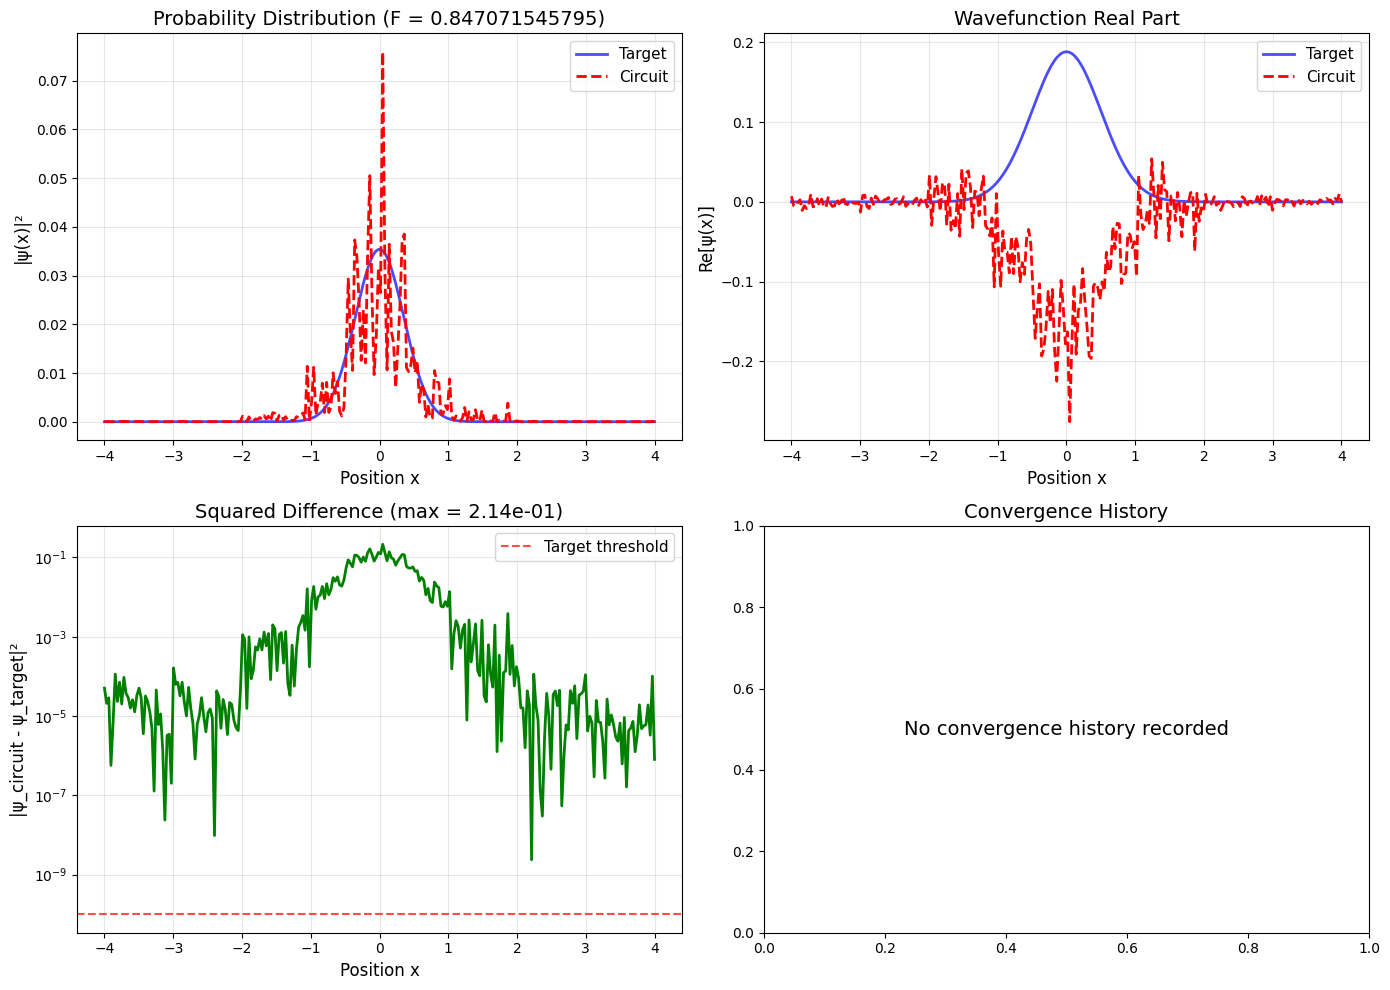

✓ Saved: full_pipeline_results.png


In [10]:
# Plot comparison
x = optimizer.positions
prob_target = np.abs(optimizer.target)**2
prob_circuit = np.abs(optimal_sv)**2

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Probability distributions
ax = axes[0, 0]
ax.plot(x, prob_target, 'b-', linewidth=2, label='Target', alpha=0.7)
ax.plot(x, prob_circuit, 'r--', linewidth=2, label='Circuit')
ax.set_xlabel('Position x', fontsize=12)
ax.set_ylabel('|ψ(x)|²', fontsize=12)
ax.set_title(f'Probability Distribution (F = {results["fidelity"]:.12f})', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# 2. Wavefunction real part
ax = axes[0, 1]
ax.plot(x, optimizer.target.real, 'b-', linewidth=2, label='Target', alpha=0.7)
ax.plot(x, optimal_sv.real, 'r--', linewidth=2, label='Circuit')
ax.set_xlabel('Position x', fontsize=12)
ax.set_ylabel('Re[ψ(x)]', fontsize=12)
ax.set_title('Wavefunction Real Part', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# 3. Squared difference (log scale)
ax = axes[1, 0]
diff = np.abs(optimal_sv - optimizer.target)**2
ax.semilogy(x, diff + 1e-30, 'g-', linewidth=2)
ax.axhline(y=1e-10, color='r', linestyle='--', alpha=0.7, label='Target threshold')
ax.set_xlabel('Position x', fontsize=12)
ax.set_ylabel('|ψ_circuit - ψ_target|²', fontsize=12)
ax.set_title(f'Squared Difference (max = {diff.max():.2e})', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, which='both')

# 4. Convergence history
ax = axes[1, 1]
if hasattr(optimizer, 'history') and optimizer.history and len(optimizer.history.get('fidelity', [])) > 0:
    fidelities = np.array(optimizer.history['fidelity'])
    infidelities = 1 - fidelities
    
    ax.semilogy(infidelities, 'b-', linewidth=1.5)
    ax.axhline(y=1e-10, color='r', linestyle='--', label='Target: 1e-10')
    ax.axhline(y=1e-6, color='orange', linestyle=':', alpha=0.7, label='1e-6')
    ax.axhline(y=1e-2, color='gray', linestyle=':', alpha=0.5, label='1e-2')
    ax.set_xlabel('Function Evaluations', fontsize=12)
    ax.set_ylabel('Infidelity (1-F)', fontsize=12)
    ax.set_title('Convergence History', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, which='both')
else:
    ax.text(0.5, 0.5, 'No convergence history recorded', 
            ha='center', va='center', transform=ax.transAxes, fontsize=14)
    ax.set_title('Convergence History', fontsize=14)

plt.tight_layout()
plt.savefig('full_pipeline_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: full_pipeline_results.png")

## 6. Higher Precision Test (Optional)

If you have more time and want to push for even higher precision:

In [11]:
RUN_ULTRA_PRECISION = False  # Set to True to run

if RUN_ULTRA_PRECISION:
    print("Running ultra-precision optimization (target: 1e-12)...")
    print("This may take 30+ minutes.\n")
    
    ultra_pipeline = OptimizationPipeline(
        mode='adaptive',
        target_fidelity=1.0 - 1e-12,
        max_total_time=1800,  # 30 minutes
        
        use_adam_stage=True,
        adam_max_steps=500,
        adam_target_fidelity=0.999,
        
        use_basin_hopping=True,
        basin_hopping_iterations=200,
        basin_hopping_target_fidelity=0.99999999,
        
        use_lbfgs_refinement=True,
        lbfgs_max_iter=10000,
        lbfgs_gtol=1e-15,
        
        verbose=True,
    )
    
    # Fresh optimizer
    ultra_optimizer = GaussianOptimizer(config)
    
    start = time.time()
    ultra_results = ultra_optimizer.run_optimization(ultra_pipeline)
    ultra_time = time.time() - start
    
    print(f"\nUltra-precision results:")
    print(f"  Fidelity:    {ultra_results['fidelity']:.15f}")
    print(f"  Infidelity:  {1-ultra_results['fidelity']:.6e}")
    print(f"  Time:        {ultra_time/60:.1f} minutes")
else:
    print("Ultra-precision test skipped.")
    print("Set RUN_ULTRA_PRECISION = True to run (takes 30+ min).")

Ultra-precision test skipped.
Set RUN_ULTRA_PRECISION = True to run (takes 30+ min).


## 7. Compare Different Qubit Counts

In [12]:
RUN_SCALING_TEST = False  # Set to True to run

if RUN_SCALING_TEST:
    qubit_counts = [6, 8, 10]
    scaling_results = {}
    
    for n_qubits in qubit_counts:
        print(f"\n{'='*60}")
        print(f"Testing {n_qubits} qubits ({2**n_qubits} grid points)")
        print(f"{'='*60}")
        
        test_config = OptimizerConfig(
            n_qubits=n_qubits,
            sigma=0.5,
            verbose=False,
            use_custatevec=HAS_CUSTATEVEC,
        )
        
        test_opt = GaussianOptimizer(test_config)
        
        # Simpler pipeline for scaling test
        test_pipeline = OptimizationPipeline(
            target_fidelity=0.999999,  # 1e-6 infidelity
            max_total_time=1000,
            use_adam_stage=True,
            adam_max_steps=500,
            use_basin_hopping=True,
            basin_hopping_iterations=50,
            use_lbfgs_refinement=True,
            verbose=True,
        )
        
        start = time.time()
        result = test_opt.run_optimization(test_pipeline)
        elapsed = time.time() - start
        
        scaling_results[n_qubits] = {
            'fidelity': result['fidelity'],
            'infidelity': 1 - result['fidelity'],
            'time': elapsed,
            'n_params': n_qubits**2,
        }
        
        print(f"  Result: F={result['fidelity']:.10f}, time={elapsed:.1f}s")
    
    # Summary
    print("\n" + "="*60)
    print("SCALING SUMMARY")
    print("="*60)
    print(f"{'Qubits':>8} {'States':>10} {'Params':>8} {'Infidelity':>12} {'Time':>10}")
    print("-"*60)
    for n, res in scaling_results.items():
        print(f"{n:>8} {2**n:>10} {res['n_params']:>8} {res['infidelity']:>12.2e} {res['time']:>10.1f}s")
else:
    print("Scaling test skipped.")
    print("Set RUN_SCALING_TEST = True to run.")

Scaling test skipped.
Set RUN_SCALING_TEST = True to run.


## 8. Save Results

In [13]:
# Save optimal parameters
np.save('full_pipeline_optimal_params.npy', results['optimal_params'])
print("✓ Saved: full_pipeline_optimal_params.npy")

# Save results summary
import json

summary = {
    'n_qubits': N_QUBITS,
    'sigma': SIGMA,
    'fidelity': float(results['fidelity']),
    'infidelity': float(1 - results['fidelity']),
    'total_time': float(total_time),
    'n_evaluations': int(results.get('n_evaluations', 0)),
    'target_achieved': bool(infidelity < 1e-10),
    'custatevec_used': HAS_CUSTATEVEC,
}

with open('full_pipeline_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print("✓ Saved: full_pipeline_summary.json")

✓ Saved: full_pipeline_optimal_params.npy
✓ Saved: full_pipeline_summary.json


## Summary

In [14]:
print("\n" + "="*70)
print("FULL PIPELINE TEST SUMMARY")
print("="*70)
print(f"\nConfiguration:")
print(f"  Qubits:        {N_QUBITS}")
print(f"  Grid points:   {2**N_QUBITS}")
print(f"  Parameters:    {N_QUBITS**2}")
print(f"  cuStateVec:    {HAS_CUSTATEVEC}")

print(f"\nPipeline:")
print(f"  1. Smart Init  → Starting point")
print(f"  2. Adam        → Fast convergence to F~0.99")
print(f"  3. Basin Hop   → Escape local minima")
print(f"  4. L-BFGS      → Machine precision")

print(f"\nResults:")
print(f"  Final Fidelity:    {results['fidelity']:.15f}")
print(f"  Final Infidelity:  {1-results['fidelity']:.6e}")
print(f"  Total Time:        {total_time:.1f}s ({total_time/60:.1f} min)")

print(f"\nTarget Achievement:")
if infidelity < 1e-12:
    print(f"  ✓✓ EXCELLENT: Infidelity < 1e-12 (machine precision)")
elif infidelity < 1e-10:
    print(f"  ✓ SUCCESS: Infidelity < 1e-10")
elif infidelity < 1e-8:
    print(f"  ~ GOOD: Infidelity < 1e-8")
elif infidelity < 1e-6:
    print(f"  ~ ACCEPTABLE: Infidelity < 1e-6")
else:
    print(f"  ✗ Target not reached")

print("\n" + "="*70)
print("Full pipeline test complete!")
print("="*70)


FULL PIPELINE TEST SUMMARY

Configuration:
  Qubits:        8
  Grid points:   256
  Parameters:    64
  cuStateVec:    True

Pipeline:
  1. Smart Init  → Starting point
  2. Adam        → Fast convergence to F~0.99
  3. Basin Hop   → Escape local minima
  4. L-BFGS      → Machine precision

Results:
  Final Fidelity:    0.847071545794578
  Final Infidelity:  1.529285e-01
  Total Time:        603.4s (10.1 min)

Target Achievement:
  ✗ Target not reached

Full pipeline test complete!
